## Undestanding the problem

Quora is a question answer platform with over 100 million visits per month, so its no surprise that there will be repeated questions with different wordings, if we dont remove this duplicacy writers may feel like they are answering to the same question multiple times.
so we need to solve this NLP problem to improve both reader and writer experience 

## Objectives

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## Performance Metric

1.log loss is the KPI because we are calculating the probabilities.

2.Confusion Matrix

## EDA

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
df=pd.read_csv("C:\\Users\kvsan\\Desktop\\Ml projects\\Quora Question Pair\\questions.csv")
df.shape

(404351, 6)

In [104]:
df1=df.copy()
df1.shape ## cutting down due to computational issues

(404351, 6)

In [105]:
df1.info() ## no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [106]:
df1.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [107]:
df1.describe()

,id,qid1,qid2,is_duplicate
count,404351.000000,404351.000000,404351.000000,404351.000000
mean,202175.000000,391840.987691,390195.973765,0.369248
std,116726.223686,228430.857607,228803.645742,0.482602
min,0.000000,1.000000,2.000000,0.000000
25%,101087.500000,193381.000000,191012.000000,0.000000
50%,202175.000000,390630.000000,388364.000000,0.000000
75%,303262.500000,589514.000000,588071.000000,1.000000
max,404350.000000,789800.000000,789801.000000,1.000000


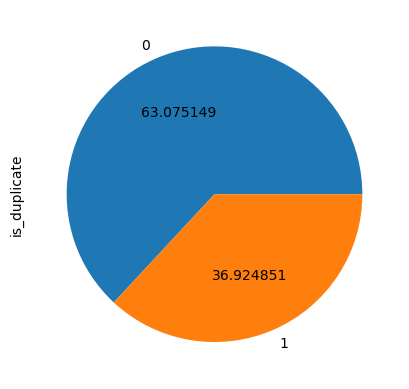

In [108]:
df1["is_duplicate"].value_counts().plot(kind="pie",autopct="%2f")
plt.show()

In [109]:
#Number of unique Questions
qids=pd.Series(df1["qid1"].tolist()+df1["qid2"].tolist())
print("number of unique questions",len(np.unique(qids)))
# Because its possible that questions pairs are unique and question are similar

number of unique questions 789801


In [110]:
print("Questions that occurs only once:",np.sum(qids.value_counts()==1))
print("Questions that occurs more than once:",np.sum(qids.value_counts()>1)) 

Questions that occurs only once: 776103
Questions that occurs more than once: 13698


In [111]:
np.sum(df.iloc[:,1:3].duplicated()) # three duplicates

3

In [112]:
df.shape

(404351, 6)

In [113]:
df=df.drop_duplicates(["qid1","qid2"])

In [114]:
df.shape # 3 duplicates has been deleted

(404348, 6)

In [115]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [116]:
df=df.fillna("")

In [117]:
df.isnull().sum() # Filled the null values with 

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Basic Feature Extraction (before cleaning) 

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [118]:
df["freq_qid1"]=df.groupby("qid1")["qid1"].transform("count")
df["freq_qid2"]=df.groupby("qid2")["qid2"].transform("count")

In [119]:
df["q1len"]=df["question1"].str.len()
df["q2len"]=df["question2"].str.len()

In [120]:
df["q1_n_words"]=df["question1"].apply(lambda row: len(row.split(" ")))
df["q2_n_words"]=df["question2"].apply(lambda row: len(row.split(" ")))

In [121]:
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

In [122]:
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

In [123]:
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

In [124]:
df["freq_q1+freq_q2"]= df["freq_qid1"]+df["freq_qid2"]
df["freq_q1-freq_q2"]= abs(df["freq_qid1"]-df["freq_qid2"])

In [125]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [126]:
df.shape

(404348, 17)

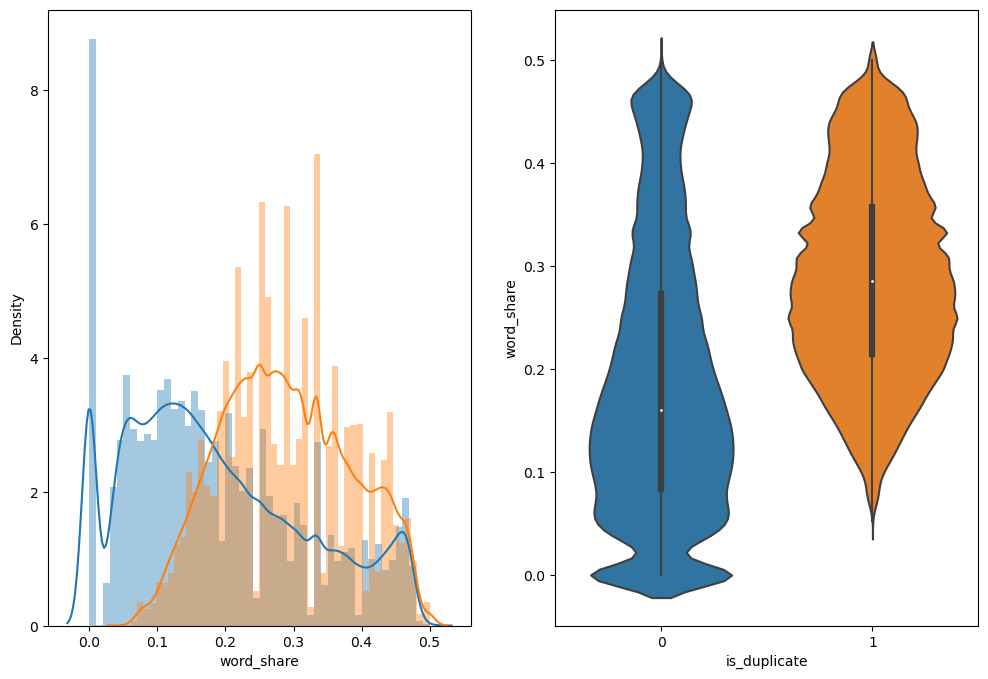

In [127]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.distplot(df[df["is_duplicate"]==0]["word_share"],label="0")
sns.distplot(df[df["is_duplicate"]==1]["word_share"],label="1")
plt.subplot(1,2,2)
sns.violinplot(x="is_duplicate",y="word_share",data=df)
plt.show()

## Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>           
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [128]:
def count_common_words(row):
    w1=set(row["question1"].split())
    w2=set(row["question2"].split())
    commonwords=w1.intersection(w2)
    if min(len(w1),len(w2))==0 or len(commonwords)==0:
        return 0
    return len(commonwords)/min(len(w1),len(w2))

In [129]:
df["cwc_min"]= df.apply(count_common_words,axis=1)

In [130]:
def count_common_words_max(row):
    w1=set(row["question1"].split())
    w2=set(row["question2"].split())
    commonwords=w1.intersection(w2)
    if max(len(w1),len(w2))==0 or len(commonwords)==0:
        return 0
    return len(commonwords)/max(len(w1),len(w2))

In [131]:
df["cwc_max"]= df.apply(count_common_words_max,axis=1)

In [132]:
def abs_len_difference(row):
    w1=set(row["question1"].split())
    w2=set(row["question2"].split())
    return abs(len(w1)-len(w2))

In [133]:
df["abs len difference"]=df.apply(abs_len_difference,axis=1)

In [134]:
## matching the number of letters
import difflib
def longest_common_substring(str1, str2):
    s = difflib.SequenceMatcher(None, str1, str2)
    match = s.find_longest_match(0, len(str1), 0, len(str2))
    return len(str1[match.a: match.a + match.size].split())


In [135]:
df['LongestCommonSubstring'] = df.apply(lambda row: longest_common_substring(row['question1'], row['question2']), axis=1)

## Text processing

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords

In [136]:
from bs4 import BeautifulSoup

In [137]:
def remove_html_tags(text):
    return BeautifulSoup(text,"html.parser").get_text()

In [138]:
df["question1"]=df["question1"].apply(remove_html_tags)

In [139]:
df["question2"]=df["question2"].apply(remove_html_tags)

In [140]:
## Removing Punctuations
import re
def remove_punctuations(text):
    return re.sub(r'[^\w\s]',"",text)
df["question1"]=df["question1"].apply(remove_punctuations)
df["question2"]=df["question2"].apply(remove_punctuations)

In [141]:
## converting to lower case
def lower_case(text):
    return text.lower()

In [142]:
## Convert to Lower Case
df["question1"]=df["question1"].apply(lower_case)
df["question2"]=df["question2"].apply(lower_case)

In [143]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()

In [144]:
def stemming(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [145]:
## Performing Steemming
df["question1"]=df["question1"].apply(stemming)
df["question2"]=df["question2"].apply(stemming)

In [146]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,cwc_min,cwc_max,abs len difference,LongestCommonSubstring
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,1,1,66,57,...,12,10.0,23.0,0.434783,2,0,0.909091,0.833333,1,12
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0,1,1,51,88,...,13,4.0,20.0,0.200000,2,0,0.500000,0.333333,4,2
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,1,1,73,59,...,10,4.0,24.0,0.166667,2,0,0.300000,0.214286,4,3
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by...,0,1,1,50,65,...,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,1,1
4,4,9,10,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,1,1,76,39,...,7,2.0,20.0,0.100000,2,0,0.285714,0.153846,6,1


In [147]:
# Removing Stop Words
import nltk
from nltk.corpus import stopwords

In [148]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kvsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [149]:
stop_wo_rds=set(stopwords.words("english"))

In [152]:
def stop_words(text):
    filter_=[word for word in text.split() if word not in stop_wo_rds]
    return  " ".join(filter_)
    

In [153]:
# Removing Stop Words
df["question1"]=df["question1"].apply(stop_words)
df["question2"]=df["question2"].apply(stop_words)

In [154]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,cwc_min,cwc_max,abs len difference,LongestCommonSubstring
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,...,12,10.0,23.0,0.434783,2,0,0.909091,0.833333,1,12
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,1,1,51,88,...,13,4.0,20.0,0.200000,2,0,0.500000,0.333333,4,2
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,73,59,...,10,4.0,24.0,0.166667,2,0,0.300000,0.214286,4,3
3,3,7,8,whi mental veri lone solv,find remaind math2324math divid 2423,0,1,1,50,65,...,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,1,1
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,1,1,76,39,...,7,2.0,20.0,0.100000,2,0,0.285714,0.153846,6,1


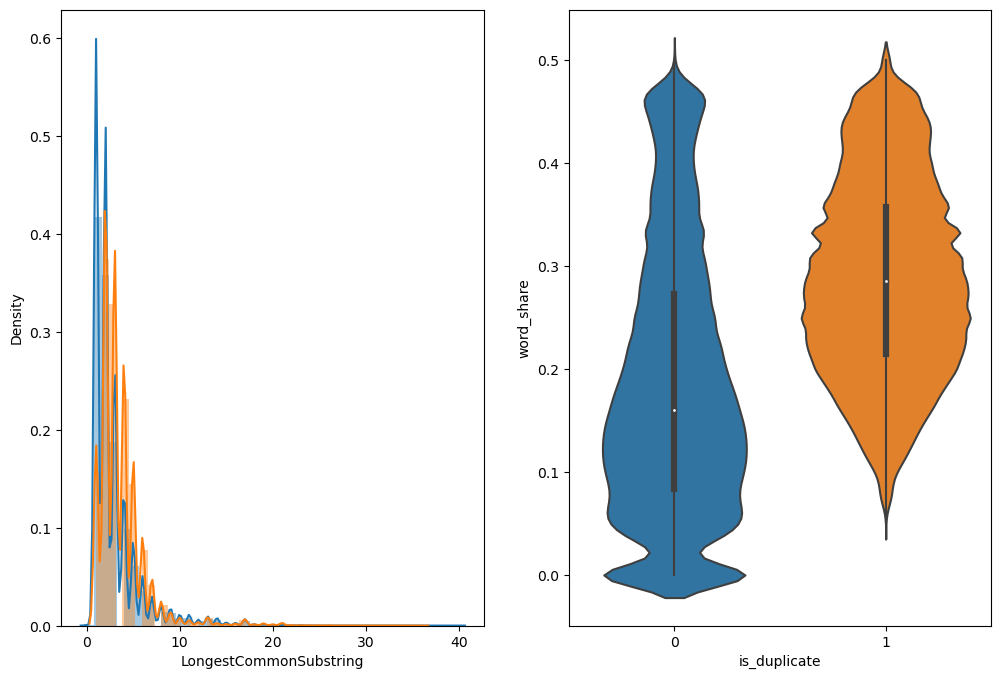

In [155]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.distplot(df[df["is_duplicate"]==0]["LongestCommonSubstring"],label="0")
sns.distplot(df[df["is_duplicate"]==1]["LongestCommonSubstring"],label="1")
plt.subplot(1,2,2)
sns.violinplot(x="is_duplicate",y="word_share",data=df)
plt.show()

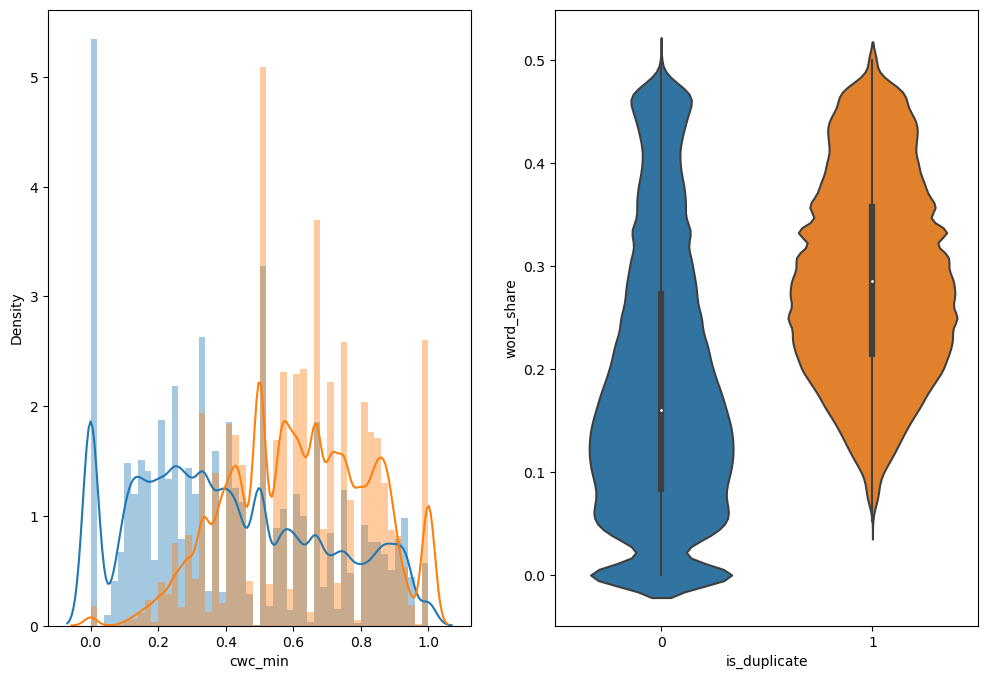

In [156]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.distplot(df[df["is_duplicate"]==0]["cwc_min"],label="0")
sns.distplot(df[df["is_duplicate"]==1]["cwc_min"],label="1")
plt.subplot(1,2,2)
sns.violinplot(x="is_duplicate",y="word_share",data=df)
plt.show()

In [157]:
# at this point we can perform tSNE to visualize the data but i am not doing it due to computational issues

## TF IDF

In [232]:
df.shape

(404348, 21)

In [233]:
df1=df.iloc[:1001,:]

In [234]:
df1.shape ## due to computational issues

(1001, 21)

In [246]:
df1

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,cwc_min,cwc_max,abs len difference,LongestCommonSubstring
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,...,12,10.0,23.0,0.434783,2,0,0.909091,0.833333,1,12
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,1,1,51,88,...,13,4.0,20.0,0.200000,2,0,0.500000,0.333333,4,2
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,73,59,...,10,4.0,24.0,0.166667,2,0,0.300000,0.214286,4,3
3,3,7,8,whi mental veri lone solv,find remaind math2324math divid 2423,0,1,1,50,65,...,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,1,1
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,1,1,76,39,...,7,2.0,20.0,0.100000,2,0,0.285714,0.153846,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,1993,1994,best share purchas sale daili trade,sydney compani would best get advic busi sale ...,0,1,1,60,88,...,16,4.0,27.0,0.148148,2,0,0.272727,0.187500,5,2
997,997,1995,1996,girlfriend privat partstouch othercan becom pr...,whi cosmet product dont price tag,0,1,1,78,56,...,10,0.0,21.0,0.000000,2,0,0.000000,0.000000,1,1
998,998,1997,1998,could use cherenkov atmospher radiat gamma ray...,map surfac subsurfac planet use cosmic ray ver...,1,1,1,145,137,...,24,13.0,46.0,0.282609,2,0,0.590909,0.541667,2,4
999,999,1999,2000,good song lyric prank,dive blue hole dahab,0,1,1,36,30,...,6,0.0,14.0,0.000000,2,0,0.000000,0.000000,2,1


In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [250]:
df1["combined"]=df1["question1"]+" "+df1["question2"]

In [251]:
tfidf=TfidfVectorizer()
tfidf_matrix=tfidf.fit_transform(df1["combined"])

In [252]:
df1.drop(["question1","question2"],axis=1,inplace=True)

In [254]:
df1=pd.concat([df1,pd.DataFrame(tfidf_matrix.toarray(),columns=tfidf.get_feature_names_out())],axis=1)

In [258]:
df1.drop("combined",inplace=True,axis=1)

In [260]:
df1.shape

(1001, 3115)

In [262]:
df1.head()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,yogurt,yojana,young,younger,youtub,youv,z630,zealand,zero,zika
0,0,1,2,0,1,1,66,57,14,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,0,1,1,51,88,8,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,6,0,1,1,73,59,14,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7,8,0,1,1,50,65,11,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,9,10,0,1,1,76,39,13,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Model

In [270]:
from sklearn.model_selection import train_test_split

In [272]:
Y=df1["is_duplicate"]
X=df1.drop("is_duplicate",axis=1)

In [276]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=20,random_state=2)

In [299]:
predicted_y=np.zeros_like(y_test,dtype=float)

In [300]:
predicted_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [301]:
for i in range(len(y_test)):
    random_=np.random.rand()
    predicted_y[i]=random_

In [302]:
y_test.shape

(20,)

In [303]:
predicted_y

array([0.94170542, 0.34937811, 0.78884619, 0.56399569, 0.04661953,
       0.1111416 , 0.66326407, 0.57613535, 0.21089925, 0.14410516,
       0.53421902, 0.74757322, 0.48869068, 0.73886848, 0.35942392,
       0.41892211, 0.98032892, 0.90177832, 0.47174398, 0.18749357])

In [305]:
from sklearn.metrics import log_loss

In [307]:
log_loss(y_test,predicted_y) ## randomly prediced dumb model has a log loss of 1.133

1.1333129080041897

## Logistic Regression

In [311]:
alpha=[10**x for x in range(-5,2)]
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [315]:
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty="l2",loss="log_loss",random_state=42)
    clf.fit(x_train,y_train)
    sig_cali=CalibratedClassifierCV(clf,method="sigmoid")
    sig_cali.fit(x_train,y_train)
    predict_=sig_cali.predict_proba(x_test)
    logloss=log_loss(y_test,predict_)
    print("For alpha:",i,"the log loss is",logloss)

For alpha: 1e-05 the log loss is 0.6023498807094781
For alpha: 0.0001 the log loss is 0.6023498807094781
For alpha: 0.001 the log loss is 0.5656787752242116
For alpha: 0.01 the log loss is 0.5587432513242863
For alpha: 0.1 the log loss is 0.5696501754530118
For alpha: 1 the log loss is 0.5436068929820073
For alpha: 10 the log loss is 0.5676659521584246


## Lr SVM

In [316]:
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty="l2",loss="hinge",random_state=42)
    clf.fit(x_train,y_train)
    sig_cali=CalibratedClassifierCV(clf,method="sigmoid")
    sig_cali.fit(x_train,y_train)
    predict_=sig_cali.predict_proba(x_test)
    logloss=log_loss(y_test,predict_)
    print("For alpha:",i,"the log loss is",logloss)

For alpha: 1e-05 the log loss is 0.6023498807094781
For alpha: 0.0001 the log loss is 0.6023498807094781
For alpha: 0.001 the log loss is 0.5490514753475597
For alpha: 0.01 the log loss is 0.5739081910723011
For alpha: 0.1 the log loss is 0.563375975836095
For alpha: 1 the log loss is 0.5464515926192326
For alpha: 10 the log loss is 0.5732150692054243


In [317]:
clf=SGDClassifier(alpha=1,penalty="l2",loss="hinge",random_state=42)
clf.fit(x_train,y_train)
sig_cali=CalibratedClassifierCV(clf,method="sigmoid")
sig_cali.fit(x_train,y_train)
predict_=sig_cali.predict_proba(x_train)
logloss=log_loss(y_train,predict_)

In [319]:
logloss # it is having more bias

0.6260385993947588

In [1]:
# we can try xg boost with grid search but iam not doing it because of computational issues